# (Prototype) COVID Dashboard

This is a prototype COVID Dashboard for testing text and graphical display of COVID-related data.

### To do list
1.  Have to add descriptions (for plot titles) and labels for Hospitalization data for time series plotting.
2.  Have to create function to handle IMHE Hospitalization data (since for most of the time series data there exist upper and lower bounds.
3.  Modify `html_status()` to somehow logically handle multiple dataframes (for example, passing it John Hopkins, Mobility, and IMHE dataframes should be allowed for state data, allowing printing of summary data from all those datasets.
4.  Consider writing a new version of plotting routine to use BQplot library, which would allow use of widgets framework for easier interactivity.  The problem is it won't overlay multiple datasets (from different dataframes) quite as easily.

In [1]:
# This forces a reload of any external library file if it changes.  
# Useful when developing external libraries since otherwise Jupyter 
# will not re-import any library without restarting the python kernel.

%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import time
from IPython.core.display import display, HTML
from COVIDlib.collectors import days_since

# Import COVID data IO routines from external python library
import COVIDlib.data_IO as COVID_IO

## Define variables of interest below
data_dir = 'our_data/'    # Data directory for the COVID datafiles

## Define FIPS corresponding to various local areas
ClayFIPS = 27027
CassFIPS = 38017
MNFIPS = 27
NDFIPS = 38

# Define titles/labels in English for John Hopkins and Mobility Data
var_descript = {'FIPS' : 'Federal Information Processing Standards State/County Number', 
                'county' : 'County Name', 
                'state' : 'State Name', 
                'Lat': 'Latitude',
                'Long_' : 'Longitude', 
                'dates' : 'Dates', 
                'Confirmed' : 'Confirmed COVID Infections', 
                'Deaths' : 'Confirmed and Probable COVID Deaths',
                'Recovered' : 'Confirmed and Probable COVID Recoveries',
                'Active' : 'Confirmed and Probable Active COVID Cases', 
                'Incident_Rate' : 'Confirmed COVID Cases',  # As provided by John Hopkins
                'People_Tested' : 'Total tested for COVID', 
                'People_Hospitalized' : 'Total hospitalized for COVID', 
                'Mortality_Rate' : 'Mortality Rate', 
                'Testing_Rate' : 'Total Tested for COVID', 
                'Hospitalization_Rate' : 'Hospitalization Rate',
                'dConfirmed' : 'COVID Infection Rate', 
                'd2Confirmed' : 'Change in COVID Infection Rate',  
                'dDeaths' : 'COVID Death Rate',  
                'd2Deaths' : 'Change in COVID Death Rate',   
                'PopEst2019' : 'Estimated Population (July 1, 2019)', 
                'PopChg2019' : 'Estimated Population Increase (2018-19)',
                'ConfirmedRate' : 'Confirmed COVID Infections (per 100,000 persons)', # As computed by us
                'DeathRate' : 'Confirmed COVID Deaths (per 100,000 people)', # As computed by us
                'driving_mobility' : 'Apple Maps Directions Requests',
                'driving_mobility_Percent' : 'Apple Maps Directions Requests',
                'retail_recreation_Percent': 'Google-tracked Retail & Recreation Activity',
                'grocery_pharm_Percent': 'Google-tracked Grocery & Pharmacy Activity',
                'parks_Percent': 'Google-tracked Park Activity',
                'transit_stations_Percent' : 'Google-tracked Transit Station Activity',
                'residential_Percent' : 'Google-tracked Residential Activity',
                'workplace_Percent' : 'Google-tracked Workplace Activity' }

var_ylabel = {'FIPS' : 'FIPS Number', 
                'county' : '', 
                'state' : '', 
                'Lat': 'Latitude (degrees)',
                'Long_' : 'Longitude (degrees)', 
                'Dates' : 'Dates', 
                'Confirmed' : 'Confirmed Infections', 
                'Deaths' : 'Confirmed and Probable Deaths',
                'Recovered' : 'Confirmed and Probable Recoveries',
                'Active' : 'Confirmed and Probable Active Cases', 
                'Incident_Rate' : 'Confirmed Cases (per 100,000 persons)',  # As provided by John Hopkins
                'People_Tested' : 'Total tested for COVID', 
                'People_Hospitalized' : 'Total hospitalized for COVID', 
                'Mortality_Rate' : 'Percent', 
                'Testing_Rate' : 'Tested (per 100,000 people)', 
                'Hospitalization_Rate' : 'Percent',
                'dConfirmed' : 'Infection Rate (Infections per day)', 
                'd2Confirmed' : 'Change in Infection Rate (Infections/day per day)',  
                'dDeaths' : 'New Deaths per day',  
                'd2Deaths' : 'Change in Death Rate (Deaths/day per day)',   
                'PopEst2019' : 'Estimated Population', 
                'PopChg2019' : 'Estimated Population Increase',
                'ConfirmedRate' : 'COVID Infections (per 100,000 persons)', # As computed by us
                'DeathRate' : 'COVID Deaths (per 100,000 people)', # As computed by us
                'driving_mobility' : 'Relative volume (vs Jan 13, 2020)',
                'driving_mobility_Percent' : 'Percent Change (vs Jan 13, 2020)',
                'retail_recreation_Percent': 'Percent Change (vs Jan 3 - Feb 6, 2020)',
                'grocery_pharm_Percent': 'Percent Change (vs Jan 3 - Feb 6, 2020)',
                'parks_Percent': 'Percent Change (vs Jan 3 - Feb 6, 2020)',
                'transit_stations_Percent' : 'Percent Change (vs Jan 3 - Feb 6, 2020)',
                'residential_Percent' : 'Percent Change (vs Jan 3 - Feb 6, 2020)',
                'workplace_Percent' : 'Percent Change (vs Jan 3 - Feb 6, 2020)' }
               

In [3]:
# Define functions to be used below

def derivative1D(x, y):
    """
    Compute forward difference estimate for the derivative of y with respect
    to x.  The x and y arrays are vectors with a single row each.

    The input and must be the same size.

    Note that we copy the first known derivative values into the zeroth column, since
    the derivatve for the first point is not a known value.
    """
    # Compute the numerator (y[i+1] - y[i]) for the entire row at once
    dy = y[1:] - y[0:-1]
    # Compute the denominator (x[i+1] - x[i]) for the entire row at once
    dx = x[1:] - x[0:-1]
    # Compute the derivatives for the entire row at once
    dydx = dy / dx
    # Get first column to horizontal stack with numpy array to pad the array
    first_col = dydx[0] 
    return np.hstack((first_col, dydx))


def cleanJHdata(JH_dataframe):
    # This function take a John Hopkins dataframe and adds confirmed infection and death rates per 100,000 
    # people to the frame as columns.  Also computes the number of active cases.
    confirmed_arr = np.array(JH_dataframe['Confirmed'].to_list())
    deaths_arr = np.array(JH_dataframe['Deaths'].to_list())
    recovered_arr = np.array(JH_dataframe['Recovered'].to_list())
    pop_arr = np.array(JH_dataframe['PopEst2019'].to_list())
    
    # Write the updated columns
    JH_dataframe['ConfirmedRate'] = np.round_(((confirmed_arr/pop_arr[:, None])*100000),2).tolist()
    JH_dataframe['DeathRate'] = np.round_(((deaths_arr/pop_arr[:, None])*100000),2).tolist()
    JH_dataframe['Active'] = (confirmed_arr - deaths_arr - recovered_arr).tolist()
    
    # Rename column to be consistent with other dataframes (simplifies plotting)
    JH_dataframe.rename(columns={ 'Dates': 'dates', 'State' : 'state', 'County': 'county'}, inplace = True)
    
    # If the maximum FIPS number is <100, this is state data, spend the extra time to process it to 
    # get totals for the United States
    if (JH_dataframe['FIPS'].max() < 100):
        print("Processing States Dataframe")
        
        # Get sums of other columns
        tested_arr = np.sum(np.array(JH_dataframe['People_Tested'].to_list()), axis=0)
        # using nansum here because it treats NaN as 0
        hospitalized_arr = np.nansum( np.array(JH_dataframe['People_Hospitalized'].to_list()) , axis=0)

        # Sum these values for the entire US as well and process them into rates
        confirmed_us_arr = np.sum(confirmed_arr, axis=0)
        deaths_us_arr = np.sum(deaths_arr, axis=0)
        recovered_us_arr = np.nansum(recovered_arr, axis=0)

        pop_us = JH_dataframe['PopEst2019'].sum() # Get sum as a scalar
        mortality = np.round_((deaths_us_arr/confirmed_us_arr)*100,2).tolist()
        ConfirmedRate_us = np.round_(((confirmed_us_arr/pop_us)*100000),2).tolist()
        DeathRate_us = np.round_(((deaths_us_arr/pop_us)*100000),2).tolist()
        Active_us = (confirmed_us_arr - deaths_us_arr - recovered_us_arr).tolist() 
        hospitalized_rate_us = np.round_(((hospitalized_arr/pop_us)*100000),2).tolist()
        testing_rate_us = np.round_(((tested_arr/pop_us)*100000),2).tolist()

        # Compute derivatives for US
        dates_list = []
        for dat in JH_dataframe['dates'][0]:
            dates_list.append( days_since(dat) )
        dates_arr = np.array([dates_list][0])

        # Compute the derivatives (using forward derivative approach)
        dconfirmed_us_arr = derivative1D(dates_arr, confirmed_us_arr)
        ddeaths_us_arr = derivative1D(dates_arr, deaths_us_arr)
        # Compute the second derivatives (a bit hinky to use forward derivative again, but...)
        d2confirmed_us_arr = derivative1D(dates_arr, dconfirmed_us_arr)
        d2deaths_us_arr = derivative1D(dates_arr, ddeaths_us_arr)


        # Build a dataframe of US information
        us_df = pd.DataFrame({"FIPS" : 0, 
                              "state" : "United States",
                              'Lat':  37.09,
                              'Long_' : -95.71,
                              'dates' : [JH_dataframe['dates'][0]],
                              'Confirmed' : [confirmed_us_arr.tolist()], 
                              'Deaths' : [deaths_us_arr.tolist()],
                              'Recovered' : [recovered_us_arr.tolist()],
                              'Active' : [Active_us], 
                              'Incident_Rate' : [[]],  # No data provided by John Hopkins
                              'People_Tested' : [tested_arr.tolist()],
                              'People_Hospitalized' : [hospitalized_arr.tolist()],
                              'Mortality_Rate' : [mortality],
                              'Testing_Rate' : [testing_rate_us], 
                              'Hospitalization_Rate' : [hospitalized_rate_us],
                              'dConfirmed' : [dconfirmed_us_arr.tolist()], 
                              'd2Confirmed' : [d2confirmed_us_arr.tolist()],  
                              'dDeaths' : [ddeaths_us_arr.tolist()],  
                              'd2Deaths' : [d2deaths_us_arr.tolist()], 
                              'PopEst2019' : pop_us, 
                              'PopChg2019' : JH_dataframe['PopChg2019'].sum(),
                              'ConfirmedRate' : [ConfirmedRate_us], # As computed by us
                              'DeathRate' : [DeathRate_us]  }) 
        
        # Append US to States dataframe
        JH_dataframe = JH_dataframe.append(us_df, ignore_index = True)
        
    return JH_dataframe


def build_fipsdict(county_df, state_df):
    # This function converts the John Hopkins state and county dataframes into a dictionary
    # that can be used to look up FIPS numbers by location name.
    
    # Start by converting states dataframe into a dictionary
    FIPSdf = state_df[['FIPS','state']].copy()
    FIPSdict = FIPSdf.set_index('state').T.to_dict('records')[0]

    # Pull FIPS, county, and state columns from county dataframe, then 
    # construct placenames and use that to append additional dictionary
    # entries for all the counties.
    FIPSdf = county_df[['FIPS','county','state']].copy()
    FIPSdf['placename'] = FIPSdf.agg('{0[county]} ({0[state]})'.format, axis=1)
    FIPSdf.drop(columns=['county', 'state'], inplace=True)
    FIPSdict.update(FIPSdf.set_index('placename').T.to_dict('records')[0])

    return FIPSdict


def cleanAAPLdata(aapl_dataframe):
    # This function takes Apple mobility dataframes and converts the mobility to percent change from baseline
    # to be consistent with Google Mobility dataframes.
    
    mobility_arr = np.array(aapl_dataframe['driving_mobility'].to_list())
    mobility_percent = mobility_arr - 100
    aapl_dataframe['driving_mobility_Percent'] = np.round_(mobility_percent,2).tolist()
    
    return


def html_status(dataframe, fips):
    ## Print an HTML statement of current status (Confirmed, Deaths, Recovered) 
    ## based on Johns Hopkins dataframes (county or State)

    ## Check if FIPS input is reasonable
    if (type(fips) == int):
        fips = [fips]
    elif (type(fips) != list):
        raise ValueError('Input fips must be integer or list of integers')
    
    # Loop through the FIPS values
    for FIPS in fips:
        local_df = COVID_IO.getLocalDataFrame(FIPS, dataframe)
        
        # Determine name to use
        if (FIPS > 100):
            namestr = f"{local_df['county'].values[0]} ({local_df['state'].values[0]})"
        else:
            # This is a state
            namestr = local_df['state'].values[0]

        # For each list item, remember its a nested list, so pull the list out [0] and then reference the 
        # last item in the nested list using index -1.
        last_day = local_df['dates'].to_list()[0][-1].strftime("%B %d, %Y")
        last_infect_tot = local_df['Confirmed'].to_list()[0][-1]
        last_recovered_tot = local_df['Recovered'].to_list()[0][-1]
        last_active_tot = local_df['Active'].to_list()[0][-1]
        last_death_tot = local_df['Deaths'].to_list()[0][-1]
        dead_percent = (last_death_tot/last_infect_tot)*100
        recovered_percent = (last_recovered_tot/last_infect_tot)*100
        active_percent = (last_active_tot/last_infect_tot)*100
        last_infectrate = local_df['ConfirmedRate'].to_list()[0][-1]
        last_deathrate = local_df['DeathRate'].to_list()[0][-1]
        last_infect_change = local_df['dConfirmed'].to_list()[0][-1]
        last_death_change = local_df['dDeaths'].to_list()[0][-1]   
        last_infect_change2 = local_df['d2Confirmed'].to_list()[0][-1]
        last_death_change2 = local_df['d2Deaths'].to_list()[0][-1]
        
        # Print HTML report
        display(HTML(f"<h3>Status of {namestr} as of {last_day}</h3>"+
                     f"<table style='padding: 5px;'>"+
                     f"<tr><td style='text-align: right;vertical-align: top;'><b style='font-size: 140%;'>{last_infect_tot:,.0f} Total Cases</b><br/>({last_infectrate} per 100,000 people)</td>"+
                     f"<td style='text-align: left;vertical-align: top;'><b><span style='color:#ff0000;'>{last_active_tot:,.0f} Active ({active_percent:.1f}%)</span> / <span style='color:rgb(0,128,20);'>{last_recovered_tot:,.0f} Recovered ({recovered_percent:.1f}%)</span> / {last_death_tot:,.0f} Dead ({dead_percent:.1f}%)</b><br/>"+
                     f"<ul><li><b>{last_infect_change:,.0f} new infections</b> in last day which is a change of {last_infect_change2:+.0f} from previous day.</li>"+
                     f"<li><b>{last_death_change:,.0f} new deaths</b> in last day which is a change of {last_death_change2:+.0f} from previous day..</li></ul></td></tr></table>"))
                
    return 
 
    
def running_average(ts_array, n_days):
    # Compute the running average of the last n_days for ts_array (assumed to be 
    # a contiguous set of data with a one day cadence).  It assumes the input is 
    # a time-series numpy array.
   
    ##
    ## Perform the running average as a sum of n_days+1 shifted time-series
    ##
    
    # Create array to store running average padded to deal with building a sum using 
    # time-shifted data
    npts = ts_array.size
    running_avg_raw = np.zeros(npts+n_days+1, float)

    for m in range(0, n_days+1):
        running_avg_raw[m : m+npts] += ts_array[:]
    running_avg_raw[:] /= n_days+1   # Divide by n_days+1 to make actual running average
    
    # Grab the slice of running_avg_raw that actually corresponds to real dates.
    # WARNING: The first n_days entries here are going to be biased low, so inserting
    # np.nan there instead
    running_avg_raw[0:n_days] = np.nan
    
    return running_avg_raw[0:npts]   


def ts_plot(dataframe, colname, fips, connectdots=False, ylog=False, running_avg=0, fig=None, ax=None):
    ## Plot up a time series of colname data from dataframe, plotting each fips provided in the list.
    
    ## Start by defaulting to a single figure and plotting it if no fig, ax values
    ## are provided
    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" if you provide one of them')
    elif fig is None and ax is None:
        fig, ax = plt.subplots(1, 1)
    
    ## Check if FIPS input is reasonable
    if (type(fips) == int):
        fips = [fips]
    elif (type(fips) != list):
        raise ValueError('Input fips must be integer or list of integers')
   
    # Label the plot
    ax.tick_params(axis='x', rotation=30) # Rotate date labels
    xlabel = ax.set_xlabel("Date")
    ylabel = ax.set_ylabel(var_ylabel[colname])
    title = ax.set_title(var_descript[colname])

    # Loop through the FIPS values
    for FIPS in fips:
        # Get dataframe
        this_frame = COVID_IO.getLocalDataFrame(FIPS, dataframe)
        
        # Determine legend label to use
        if (FIPS > 100):
            labelstr = f"{this_frame['county'].values[0]} ({this_frame['state'].values[0]})"
        else:
            # This is a state
            labelstr = this_frame['state'].values[0]
        
        # retrieve the data (nan values are automatically excluded)
        dates = np.array(this_frame['dates'].to_list()[0])
        var = np.array(this_frame[colname].to_list()[0])
        
        # If the running average is set to a value greater than zero, compute and plot the
        # running average instead of raw data
        if (running_avg > 0):
            var = running_average(var, running_avg)
            labelstr = labelstr+f" [{running_avg:d} day running avg]"
            
        if (connectdots):
            ls='-'
        else:
            ls ='None'
        
        # Plot the data for this FIPS record
        ax.plot(dates, var, marker='o', markersize=3, linestyle=ls, label=labelstr)
    
    # Adjust y axis to be logarithmic if requested
    if (ylog):
        ax.set_yscale('log')
    
    # Add legend
    legend = ax.legend()
    
    
def ts_barplot(dataframe, colname, fips, ylog=False, running_avg=0, fig=None, ax=None):
    ## Plot up bar graph of a time series of colname data from dataframe and a SINGLE fips
    
    ## Start by defaulting to a single figure and plotting it if no fig, ax values
    ## are provided
    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" if you provide one of them')
    elif fig is None and ax is None:
        fig, ax = plt.subplots(1, 1)
    
    ## Check if FIPS input is reasonable
    if (type(fips) != int):
        raise ValueError('Input fips must be integer')
   
    # Get dataframe
    this_frame = COVID_IO.getLocalDataFrame(fips, dataframe)

    # Determine legend label to use
    if (fips > 100):
        labelstr = f"{this_frame['county'].values[0]} ({this_frame['state'].values[0]})"
    else:
        # This is a state
        labelstr = this_frame['state'].values[0]
        
    # Label the plot
    ax.tick_params(axis='x', rotation=30) # Rotate date labels
    xlabel = ax.set_xlabel("Date")
    ylabel = ax.set_ylabel(var_ylabel[colname])
    titlestr = var_descript[colname]+f" for {labelstr}"
    if (running_avg > 0):
        titlestr = titlestr + f" (with {running_avg} day running average)"
    title = ax.set_title(titlestr)

    # plot the bar graph of the data 
    dates = np.array(this_frame['dates'].to_list()[0])
    var = np.array(this_frame[colname].to_list()[0])
    ax.bar(dates, var, width=0.5, color='lightcoral')

    # If the running average is set to a value greater than zero, ALSO plot the running
    # average in addition to the bar graph of the time series.
    if (running_avg > 0):
        var = running_average(var, running_avg)
        ax.plot(dates, var, marker='.', markersize=1, color='blue', linestyle='-', linewidth=2)
    
    # Adjust y axis to be logarithmic if requested
    if (ylog):
        ax.set_yscale('log')

In [4]:
# Load all the dataframes into memory
print("Loading Complete COVID Dataset into memory ... ", end='')

start= time.perf_counter()
# Retrieve John Hopkins dataframes and add "rates" of deaths/infections
(JH_state_df, JH_cnty_df) = COVID_IO.PtoCDRDataFrames()
JH_state_df = cleanJHdata(JH_state_df)
JH_cnty_df = cleanJHdata(JH_cnty_df)

# Construct dictionary of FIPS values by placename
FIPSd = build_fipsdict(JH_cnty_df, JH_state_df)

# Retrieve Apple Mobility Dataframe
(aapl_cnty_df, aapl_state_df) = COVID_IO.PtoAAPLMobilityDataFrames()
cleanAAPLdata(aapl_cnty_df)
cleanAAPLdata(aapl_state_df)

# Retrieve Google Mobility Dataframe
(goog_cnty_df, goog_state_df) = COVID_IO.PtoGOOGMobilityDataFrames()

# Retrieve IMHE Dataframes
(summary_df, hospitalization_df) = COVID_IO.PtoIMHEDataFrames()

end= time.perf_counter()

print(f"Done ({end-start:0.2f} sec)")

Loading Complete COVID Dataset into memory ... Processing States Dataframe
Done (1.39 sec)


In [5]:
# Narrow data down to local subsets
print("Extract some local variables ... ", end='')
start= time.perf_counter()

# Build local variables of IMHE data
MN_icu_beds = COVID_IO.GetNumICUBeds(MNFIPS, summary_df)
MN_all_beds = COVID_IO.GetNumAllBeds(MNFIPS, summary_df)
MN_icu_usage = COVID_IO.GetICUBedUsage(MNFIPS, summary_df)
MN_allbed_usage = COVID_IO.GetAllBedUsage(MNFIPS, summary_df)
MN_hospital_df = COVID_IO.getLocalDataFrame(MNFIPS, hospitalization_df)
ND_equip_df = COVID_IO.getLocalDataFrame(NDFIPS, summary_df)
ND_icu_beds = COVID_IO.GetNumICUBeds(NDFIPS, summary_df)
ND_all_beds = COVID_IO.GetNumAllBeds(NDFIPS, summary_df)
ND_icu_usage = COVID_IO.GetICUBedUsage(NDFIPS, summary_df)
ND_allbed_usage = COVID_IO.GetAllBedUsage(NDFIPS, summary_df)

end= time.perf_counter()
print(f"Done ({end-start:0.2f} sec)")

Extract some local variables ... Done (0.01 sec)


In [6]:
# Quick experiment to see if we can sum up all the current Infections and Deaths in the US
display(HTML(f'<h1>COVID-19 Information</h1>'))

# Print status reports
states = [FIPSd['United States'], MNFIPS, NDFIPS]
html_status(JH_state_df, states)
counties = [ClayFIPS, CassFIPS, FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]
html_status(JH_cnty_df, counties)


"1,994,701 Total Cases(607.7 per 100,000 people)","1,348,679 Active (67.6%) / 533,257 Recovered (26.7%) / 112,765 Dead (5.7%)20,830 new infections in last day which is a change of +2911 from previous day.929 new deaths in last day which is a change of -54 from previous day.."


"28,869 Total Cases(511.9 per 100,000 people)","2,927 Active (10.1%) / 24,675 Recovered (85.5%) / 1,267 Dead (4.4%)346 new infections in last day which is a change of +47 from previous day.39 new deaths in last day which is a change of +19 from previous day.."


"2,941 Total Cases(385.93 per 100,000 people)","386 Active (13.1%) / 2,482 Recovered (84.4%) / 73 Dead (2.5%)40 new infections in last day which is a change of +19 from previous day.1 new deaths in last day which is a change of +1 from previous day.."


"490 Total Cases(762.98 per 100,000 people)",459 Active (93.7%) / 0 Recovered (0.0%) / 31 Dead (6.3%)9 new infections in last day which is a change of -3 from previous day.1 new deaths in last day which is a change of +1 from previous day..


"1,958 Total Cases(1076.28 per 100,000 people)","1,897 Active (96.9%) / 0 Recovered (0.0%) / 61 Dead (3.1%)28 new infections in last day which is a change of +15 from previous day.1 new deaths in last day which is a change of +1 from previous day.."


"2,081 Total Cases(1291.94 per 100,000 people)","2,064 Active (99.2%) / 0 Recovered (0.0%) / 17 Dead (0.8%)5 new infections in last day which is a change of +0 from previous day.0 new deaths in last day which is a change of -1 from previous day.."


"740 Total Cases(467.49 per 100,000 people)",728 Active (98.4%) / 0 Recovered (0.0%) / 12 Dead (1.6%)13 new infections in last day which is a change of +8 from previous day.0 new deaths in last day which is a change of +0 from previous day..


## Display Infections and Deaths for the United States

We show a bunch of the infection and death data here.  The derivative (e.g. infections/day) and second derivative (e.g. (infections/day)/day) we computed show a lot of variation apparently depending on the day of the week.  I overlay a running average as well to see the trend.

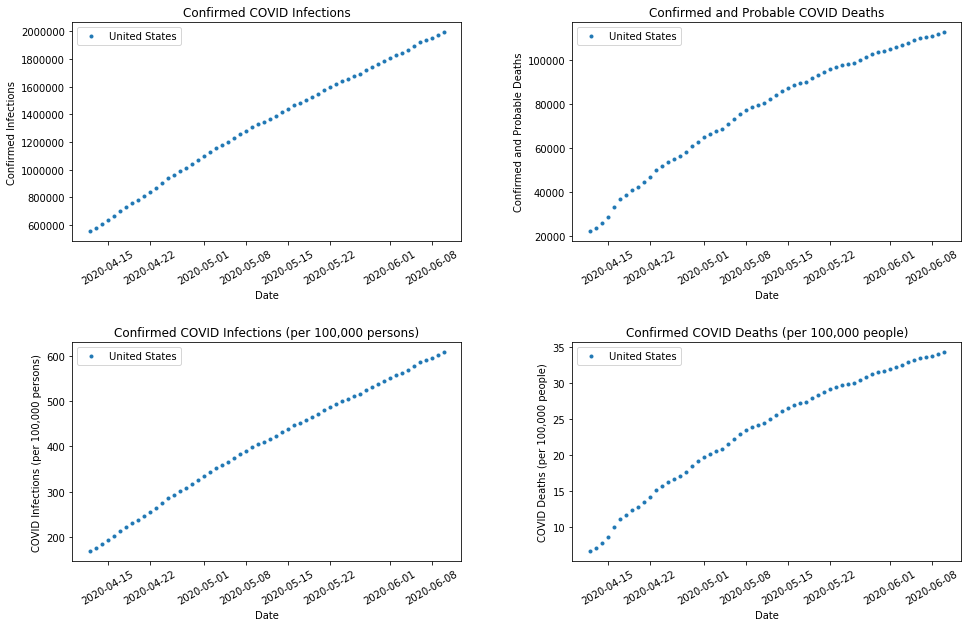

In [7]:
#
# Testing my function for plotting up time-series data (using states)
#
states = [FIPSd['United States']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col]
ts_plot(JH_state_df, 'Confirmed', states, fig=fig, ax=axs[0, 0]) # Upper Left
ts_plot(JH_state_df, 'ConfirmedRate', states, fig=fig, ax=axs[1, 0]) # Lower Left
ts_plot(JH_state_df, 'Deaths', states, fig=fig, ax=axs[0, 1]) # Upper Right
ts_plot(JH_state_df, 'DeathRate', states, fig=fig, ax=axs[1, 1]) # Lower Right

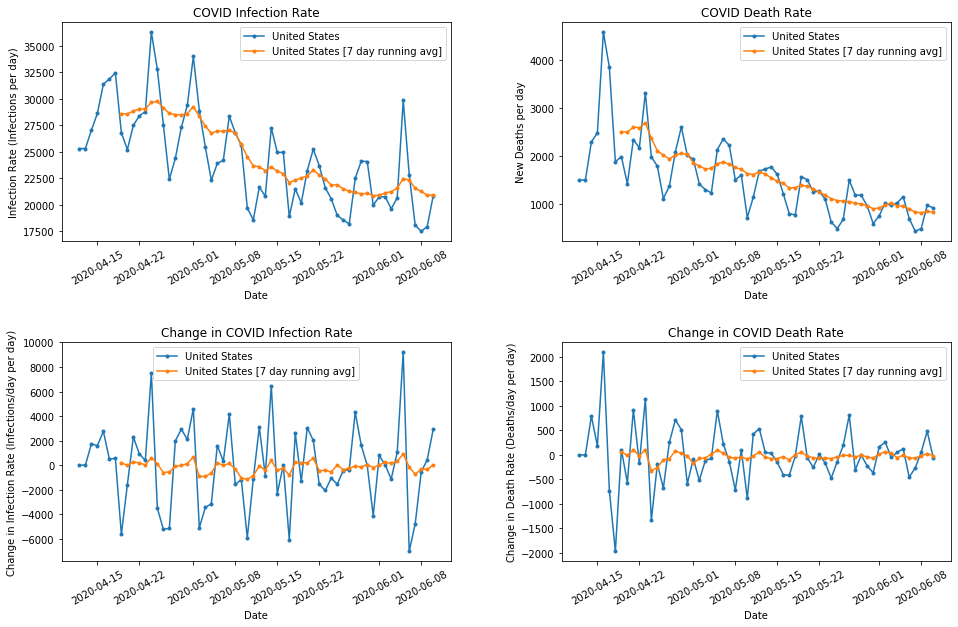

In [8]:
#
# Lets plot up the infection and death rates per day
#
states = [FIPSd['United States']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col] for single row
ts_plot(JH_state_df, 'dConfirmed', states, connectdots=True, fig=fig, ax=axs[0, 0])
ts_plot(JH_state_df, 'dConfirmed', states, connectdots=True, running_avg=7, fig=fig, ax=axs[0, 0])
ts_plot(JH_state_df, 'dDeaths', states, connectdots=True, fig=fig, ax=axs[0, 1])
ts_plot(JH_state_df, 'dDeaths', states, connectdots=True, running_avg=7, fig=fig, ax=axs[0, 1])
ts_plot(JH_state_df, 'd2Confirmed', states, connectdots=True, fig=fig, ax=axs[1, 0])
ts_plot(JH_state_df, 'd2Confirmed', states, connectdots=True, running_avg=7, fig=fig, ax=axs[1, 0])
ts_plot(JH_state_df, 'd2Deaths', states, connectdots=True, fig=fig, ax=axs[1, 1])
ts_plot(JH_state_df, 'd2Deaths', states, connectdots=True, running_avg=7, fig=fig, ax=axs[1, 1])

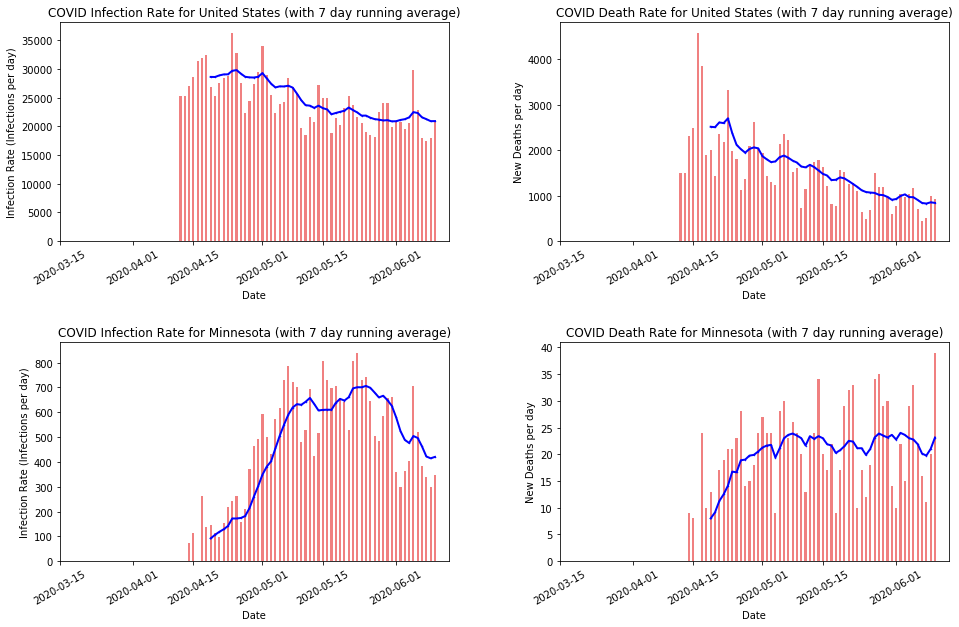

In [9]:
# Try to make a bar graph version of the infections and deaths as well

#
# Lets plot up the infection and death rates per day
#

# Set up a figure of 1 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col] for single row
# ts_barplot can only handle a SINGLE FIPS number, not a list
ts_barplot(JH_state_df, 'dConfirmed', FIPSd['United States'], running_avg=7, fig=fig, ax=axs[0, 0])
ts_barplot(JH_state_df, 'dDeaths', FIPSd['United States'], running_avg=7, fig=fig, ax=axs[0, 1])
ts_barplot(JH_state_df, 'dConfirmed', FIPSd['Minnesota'], running_avg=7, fig=fig, ax=axs[1, 0])
ts_barplot(JH_state_df, 'dDeaths', FIPSd['Minnesota'], running_avg=7, fig=fig, ax=axs[1, 1])

# Adjust the minimum date to be March 15 on all plots
adjust_bounds00 = axs[0, 0].set_xlim( [datetime.date(2020, 3, 15), axs[0, 0].get_xlim()[1]])
adjust_bounds01 = axs[0, 1].set_xlim( [datetime.date(2020, 3, 15), axs[0, 1].get_xlim()[1]])
adjust_bounds10 = axs[1, 0].set_xlim( [datetime.date(2020, 3, 15), axs[1, 0].get_xlim()[1]])
adjust_bounds11 = axs[1, 1].set_xlim( [datetime.date(2020, 3, 15), axs[1, 1].get_xlim()[1]])

## Infections and Deaths for Nearby States

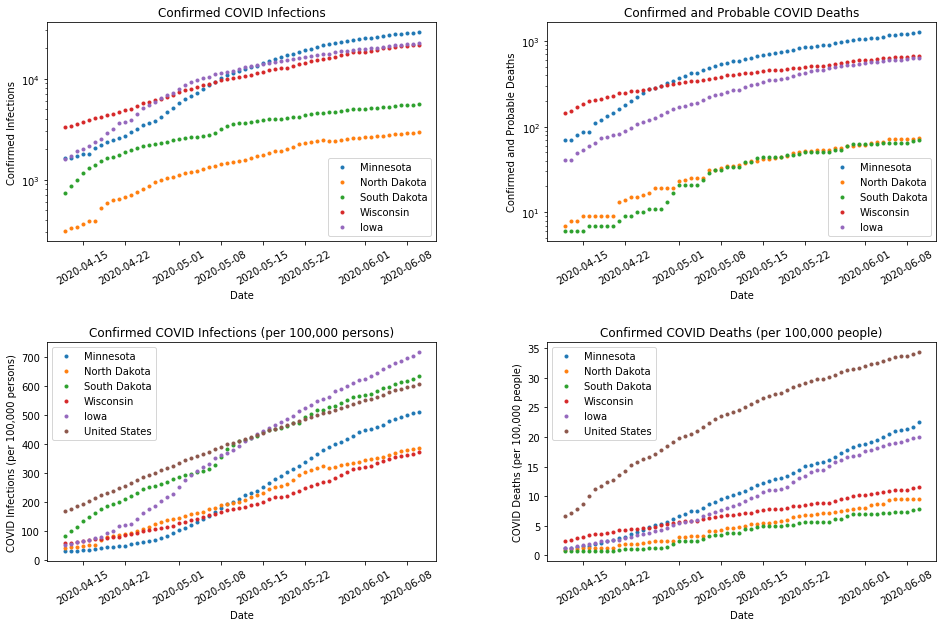

In [10]:
#
# Testing my function for plotting up time-series data (using states)
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
statesNus = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa'], FIPSd['United States']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col]
ts_plot(JH_state_df, 'Confirmed', states, ylog=True, fig=fig, ax=axs[0, 0]) # Upper Left
ts_plot(JH_state_df, 'ConfirmedRate', statesNus, fig=fig, ax=axs[1, 0]) # Lower Left
ts_plot(JH_state_df, 'Deaths', states, ylog=True, fig=fig, ax=axs[0, 1]) # Upper Right
ts_plot(JH_state_df, 'DeathRate', statesNus, fig=fig, ax=axs[1, 1]) # Lower Right

## Infections and Deaths for Some Selected Counties

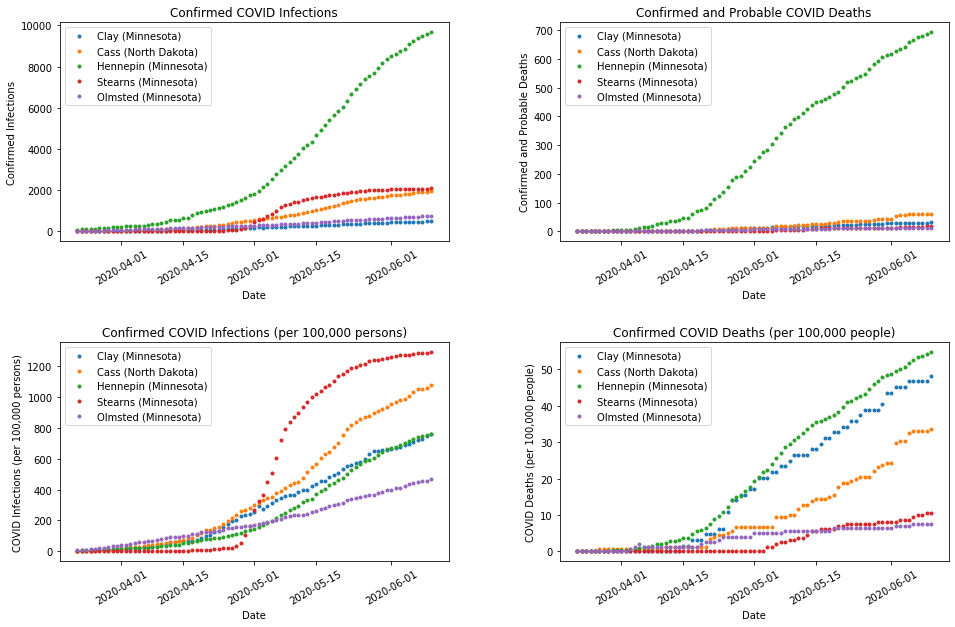

In [11]:
#
# Testing my function for plotting up time-series data (using counties)
#
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col]
ts_plot(JH_cnty_df, 'Confirmed', counties, fig=fig, ax=axs[0, 0]) # Upper Left
ts_plot(JH_cnty_df, 'ConfirmedRate', counties, fig=fig, ax=axs[1, 0]) # Lower Left
ts_plot(JH_cnty_df, 'Deaths', counties, fig=fig, ax=axs[0, 1]) # Upper Right
ts_plot(JH_cnty_df, 'DeathRate', counties, fig=fig, ax=axs[1, 1]) # Lower Right
    

## Infections and Deaths for a Mixture of States and Counties

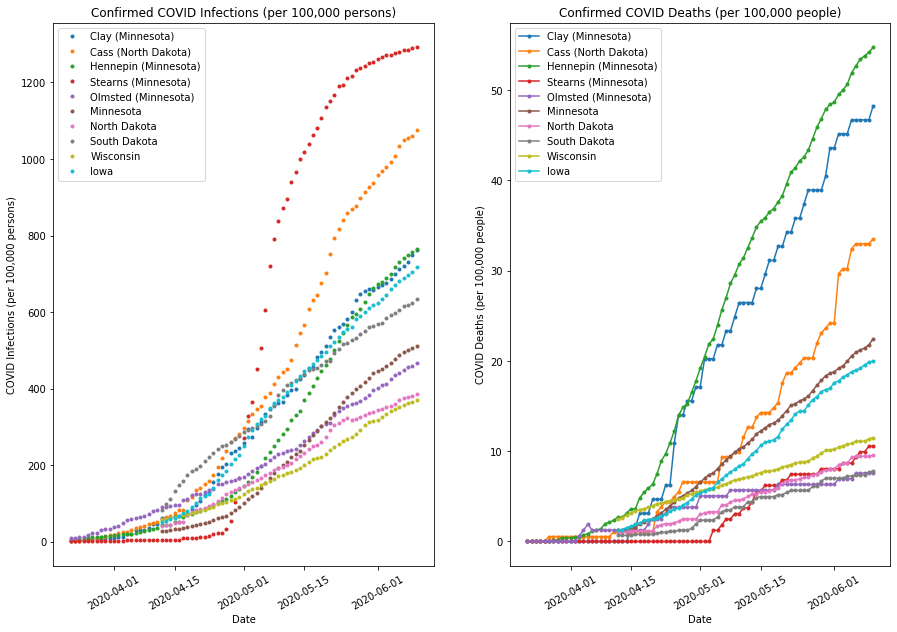

In [12]:
#
# Producing a plot of 2 plots next to each other, this makes the axis argument returned by subplots a 1-D list
# This example also shows how we can overlay state and county data when appropriate, just run the time-series function
# on the same axis element and it will update it instead of erasing it.
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a single figure
fig, axs = plt.subplots(1, 2, figsize=(15,10))

ts_plot(JH_cnty_df, 'ConfirmedRate', counties, fig=fig, ax=axs[0]) # Counties
ts_plot(JH_state_df, 'ConfirmedRate', states, fig=fig, ax=axs[0]) # States
ts_plot(JH_cnty_df, 'DeathRate', counties, connectdots=True, fig=fig, ax=axs[1]) # Counties
ts_plot(JH_state_df, 'DeathRate', states, connectdots=True, fig=fig, ax=axs[1]) # States

# You could execute a command like this to save the image to a file (it automatically determines file
# format based on the suffix).  
# plt.savefig("COVID_data.png")

## People Tested in Nearby States

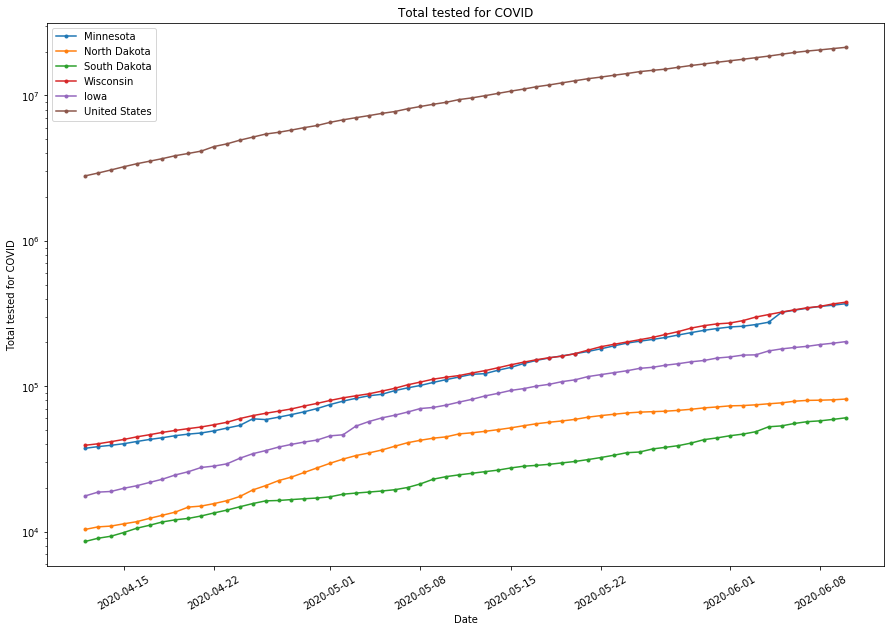

In [13]:
#
# Producing a single plot makes the axis argument returned by subplots a scalar, also using
# logarithmic axis by adjusting the plot after the fact
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa'], FIPSd['United States']]

# Set up a single figure
fig, axs = plt.subplots(1, 1, figsize=(15,10))

ts_plot(JH_state_df, 'People_Tested', states, connectdots=True, ylog=True,  fig=fig, ax=axs) # States

## Infection and Death  Per Day

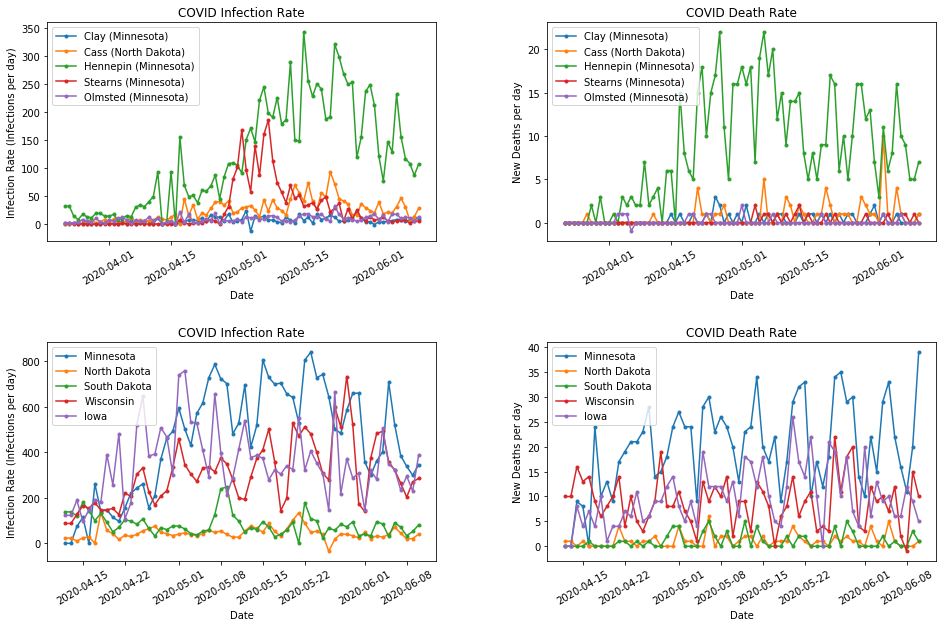

In [14]:
#
# Lets plot up the infection and death rates per day
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col]
ts_plot(JH_cnty_df, 'dConfirmed', counties, connectdots=True, fig=fig, ax=axs[0, 0]) # Upper Left
ts_plot(JH_state_df, 'dConfirmed', states, connectdots=True, fig=fig, ax=axs[1, 0]) # Lower Left
ts_plot(JH_cnty_df, 'dDeaths', counties, connectdots=True, fig=fig, ax=axs[0, 1]) # Upper Right
ts_plot(JH_state_df, 'dDeaths', states, connectdots=True, fig=fig, ax=axs[1, 1]) # Lower Right

## Change in Rate of Infections and Deaths Per Day for Selected Counties

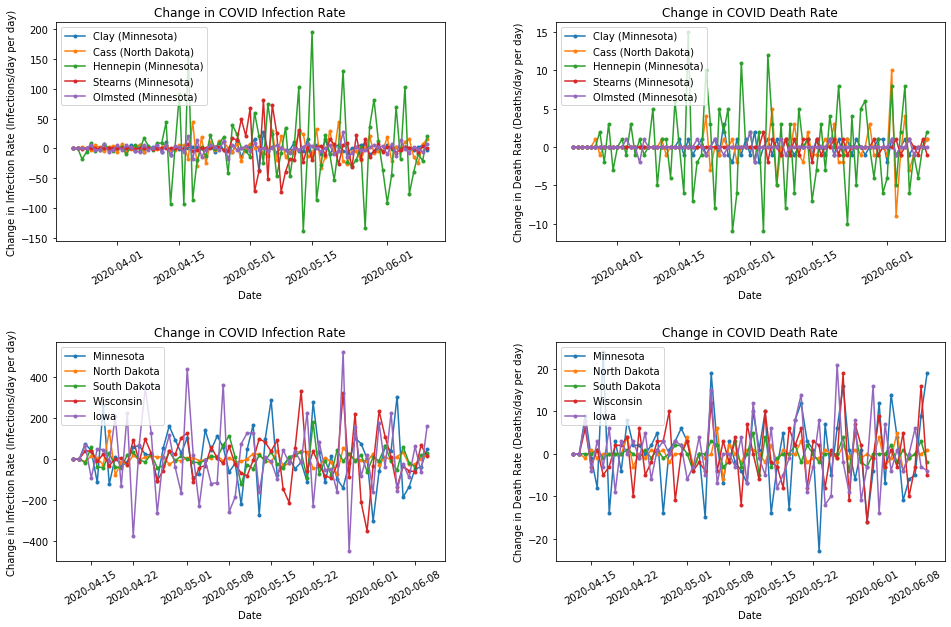

In [15]:
#
# Lets plot up the changes in those infection and death rates per day (This shows that this data likely needs to be smoothed
# to see trends).mobiiliuty
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Hennepin (Minnesota)'], FIPSd['Stearns (Minnesota)'], FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col]
ts_plot(JH_cnty_df, 'd2Confirmed', counties, connectdots=True, fig=fig, ax=axs[0, 0]) # Upper Left
ts_plot(JH_state_df, 'd2Confirmed', states, connectdots=True, fig=fig, ax=axs[1, 0]) # Lower Left
ts_plot(JH_cnty_df, 'd2Deaths', counties, connectdots=True, fig=fig, ax=axs[0, 1]) # Upper Right
ts_plot(JH_state_df, 'd2Deaths', states, connectdots=True, fig=fig, ax=axs[1, 1]) # Lower Right

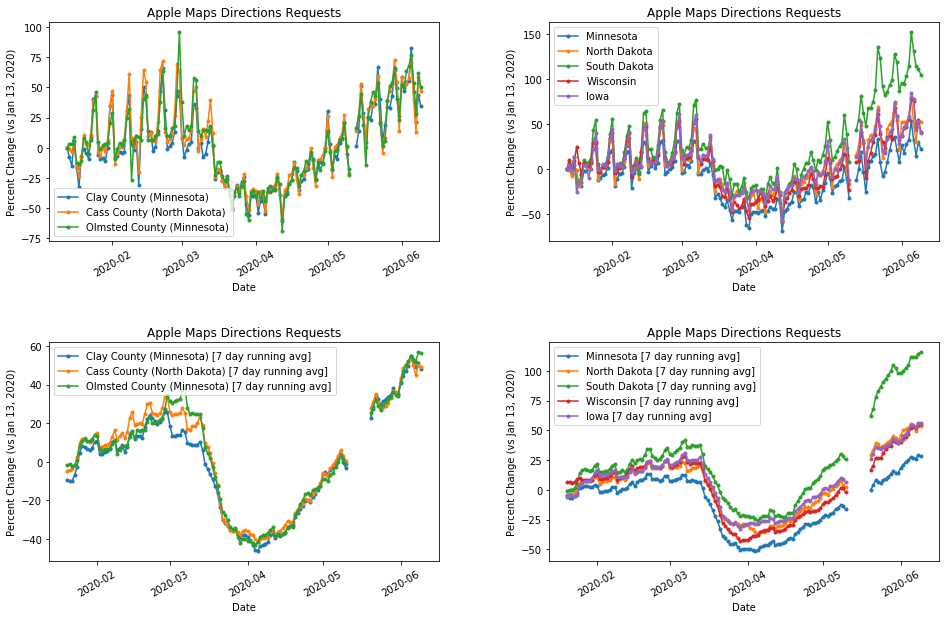

In [16]:
#
# Testing my function for plotting up time-series mobility data
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col]
ts_plot(aapl_cnty_df, 'driving_mobility_Percent', counties, connectdots=True, fig=fig, ax=axs[0, 0])
ts_plot(aapl_state_df, 'driving_mobility_Percent', states, connectdots=True, fig=fig, ax=axs[0, 1]) 
ts_plot(aapl_cnty_df, 'driving_mobility_Percent', counties, running_avg=7, connectdots=True, fig=fig, ax=axs[1, 0])
ts_plot(aapl_state_df, 'driving_mobility_Percent', states, running_avg=7, connectdots=True, fig=fig, ax=axs[1, 1]) 

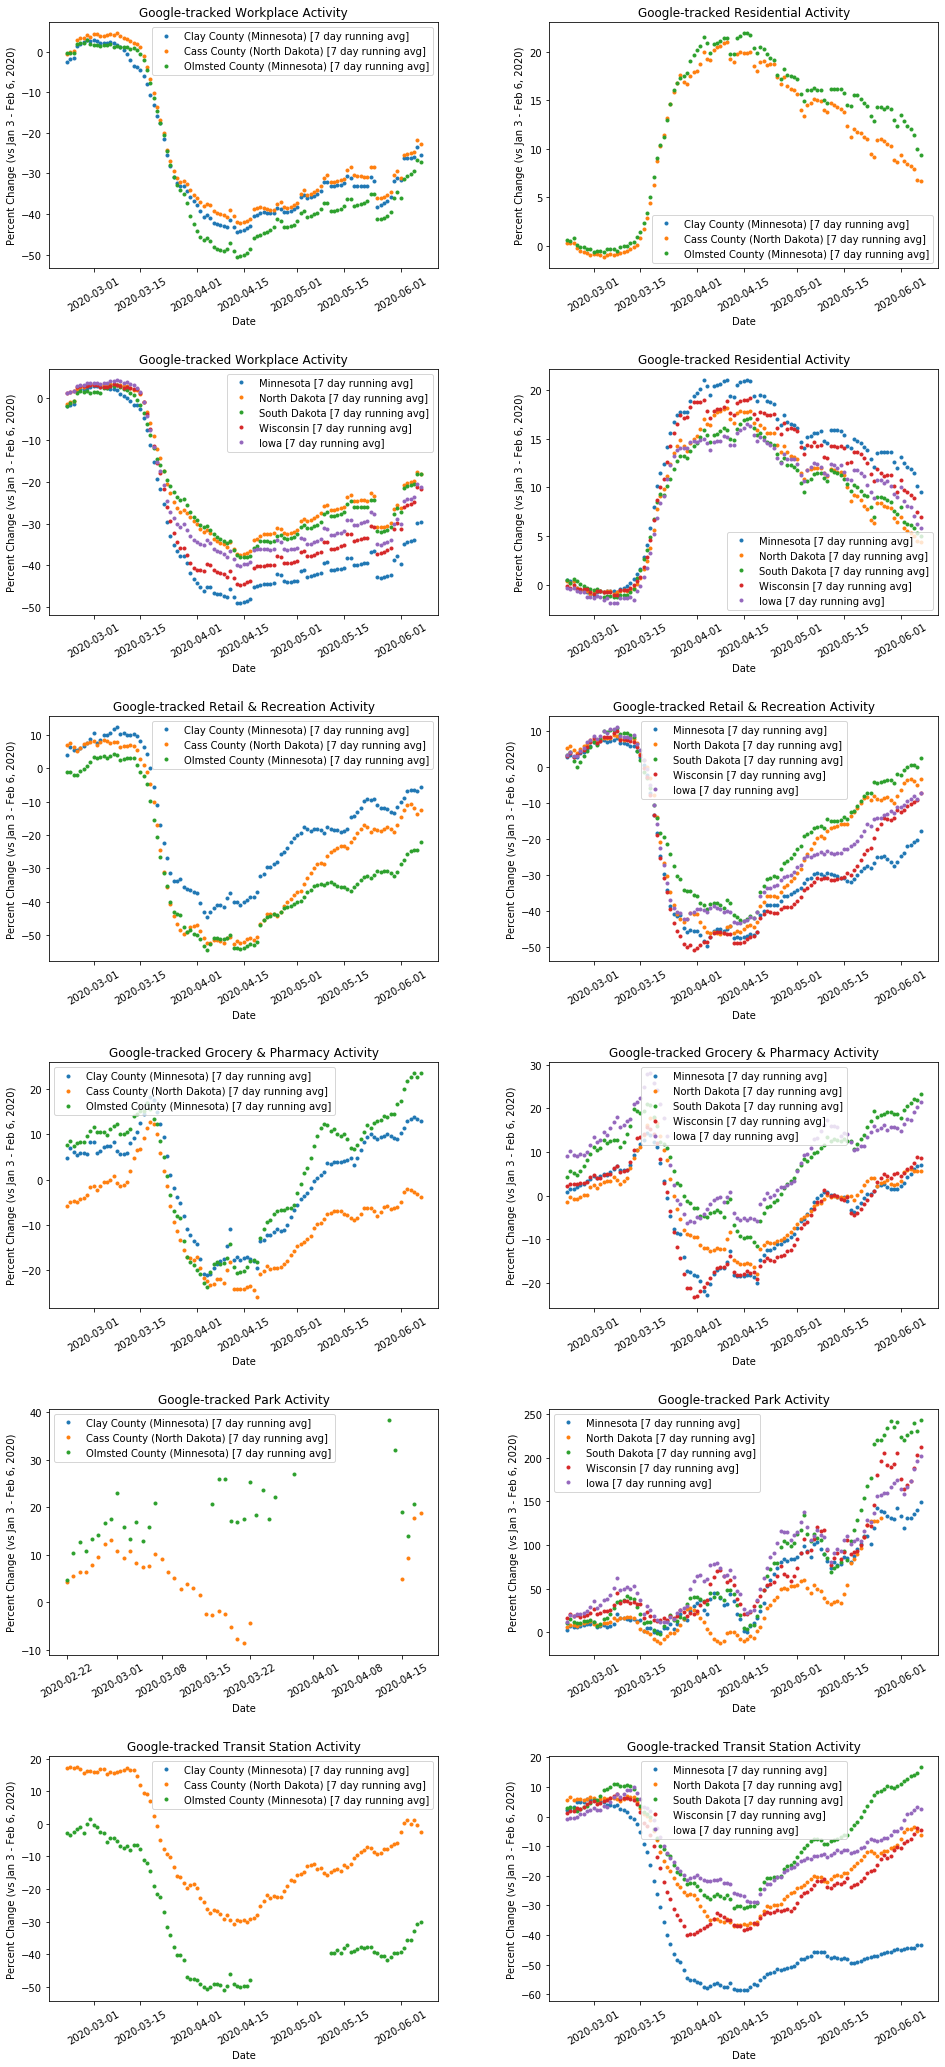

In [17]:
#
# Again, testing my function for plotting up time-series mobility data 
# (this time using running averages to smooth the data).
#
states = [MNFIPS, NDFIPS, FIPSd['South Dakota'], FIPSd['Wisconsin'], FIPSd['Iowa']]
counties = [ClayFIPS, CassFIPS, FIPSd['Olmsted (Minnesota)']]

# Set up a figure of 6 x 2 plots
fig, axs = plt.subplots(6, 2, figsize=(15,30))
fig.tight_layout(pad=8.0)

# Axis numbers here can be viewed as [row, col] 
ts_plot(goog_cnty_df, 'workplace_Percent', counties, running_avg=7, fig=fig, ax=axs[0,0])
ts_plot(goog_state_df, 'workplace_Percent', states, running_avg=7, fig=fig, ax=axs[1, 0]) 
ts_plot(goog_cnty_df, 'residential_Percent', counties, running_avg=7, fig=fig, ax=axs[0, 1])
ts_plot(goog_state_df, 'residential_Percent', states, running_avg=7, fig=fig, ax=axs[1, 1]) 
ts_plot(goog_cnty_df, 'retail_recreation_Percent', counties, running_avg=7, fig=fig, ax=axs[2, 0])
ts_plot(goog_state_df, 'retail_recreation_Percent', states, running_avg=7, fig=fig, ax=axs[2, 1]) 
ts_plot(goog_cnty_df, 'grocery_pharm_Percent', counties, running_avg=7, fig=fig, ax=axs[3, 0])
ts_plot(goog_state_df, 'grocery_pharm_Percent', states, running_avg=7, fig=fig, ax=axs[3, 1]) 
ts_plot(goog_cnty_df, 'parks_Percent', counties, running_avg=7, fig=fig, ax=axs[4, 0])
ts_plot(goog_state_df, 'parks_Percent', states, running_avg=7, fig=fig, ax=axs[4, 1]) 
ts_plot(goog_cnty_df, 'transit_stations_Percent', counties, running_avg=7, fig=fig, ax=axs[5, 0])
ts_plot(goog_state_df, 'transit_stations_Percent', states, running_avg=7, fig=fig, ax=axs[5, 1]) 

In [81]:
def html_status_beds(dataframe, fips):
    ## Print an HTML statement of current status (Confirmed, Deaths, Recovered) 
    ## based on Johns Hopkins dataframes (county or State)

    ## Check if FIPS input is reasonable
    if (type(fips) == int):
        fips = [fips]
    elif (type(fips) != list):
        raise ValueError('Input fips must be integer or list of integers')
        
    
    local_df = COVID_IO.getLocalDataFrame(fips[0], dataframe)
    namestr = local_df['state'].values[0]
    
    # Getting total of beds and number of beds used
    num_icu_beds_used = int(COVID_IO.GetICUBedUsage(fips[0], dataframe))
    num_icu_beds_total = int(COVID_IO.GetNumICUBeds(fips[0], dataframe))
    num_reg_beds_used = int(COVID_IO.GetAllBedUsage(fips[0], dataframe))
    num_reg_beds_total = int(COVID_IO.GetNumAllBeds(fips[0], dataframe))
    
    # Calculating percent of beds used
    percent_icu_used = float(num_icu_beds_used / num_icu_beds_total) * 100
    percent_reg_used = float(num_reg_beds_used / num_reg_beds_total) * 100

        
    # Print HTML report
    display(HTML(f"<h2>Status of Hospital Beds in {namestr}</h2>"+
                f"<table style='padding: 5px;'>"+
                f"<tr><td style='text-align: left;vertical-align: top;'><b style='font-size: 140%;'>{num_icu_beds_used} ICU Beds Being Used</b><br/></td>"+
                f"<tr><td style='text-align: left;vertical-align: top;'><b style='font-size: 140%;'>{num_reg_beds_used} Regular Beds Being Used</b><br/></td>"+
                f"<tr><td style='text-align: left;vertical-align: top;'><b style='font-size: 140%;'>{num_icu_beds_total} Total ICU Beds</b><br/></td>"+
                f"<tr><td style='text-align: left;vertical-align: top;'><b style='font-size: 140%;'>{num_reg_beds_total} Total Beds</b><br/></td>"+
                f"<tr><td style='text-align: left;vertical-align: top;'><b style='font-size: 140%;'>{percent_icu_used:,.2f}% ICU Beds Used</b><br/></td>"+
                f"<tr><td style='text-align: left;vertical-align: top;'><b style='font-size: 140%;'>{percent_reg_used:,.2f}% Regular Beds Used</b><br/></td>"+
                "</td></tr></table>"))
                
    return

In [82]:
html_status_beds(summary_df, MNFIPS)
html_status_beds(summary_df, NDFIPS)

785 ICU Beds Being Used
10212 Regular Beds Being Used
1140 Total ICU Beds
15196 Total Beds
68.86% ICU Beds Used
67.20% Regular Beds Used


132 ICU Beds Being Used
2234 Regular Beds Being Used
219 Total ICU Beds
3779 Total Beds
60.27% ICU Beds Used
59.12% Regular Beds Used
